# Asthma Prediction ( Classification )

In [1]:
# Import required libraries
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations and arrays
import seaborn as sns  # Statistical data visualization
import matplotlib.pyplot as plt  # Static, animated, and interactive visualizations
import re  # Regular expression operations for text processing

# Machine learning libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# For saving and loading models and large data
import joblib
import pickle

# For hyperparameter optimization
from scipy.stats import uniform, randint

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/asthma_disease_data.csv")

In [3]:
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,...,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,DoctorInCharge
0,5034,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,...,1.369051,4.941206,0,0,1,0,0,1,0,Dr_Confid
1,5035,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,...,2.197767,1.702393,1,0,0,1,1,1,0,Dr_Confid
2,5036,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,...,1.698011,5.022553,1,1,1,0,1,1,0,Dr_Confid
3,5037,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,...,3.032037,2.300159,1,0,1,1,1,0,0,Dr_Confid
4,5038,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,...,3.470589,3.067944,1,1,1,0,0,1,0,Dr_Confid


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               2392 non-null   int64  
 1   Age                     2392 non-null   int64  
 2   Gender                  2392 non-null   int64  
 3   Ethnicity               2392 non-null   int64  
 4   EducationLevel          2392 non-null   int64  
 5   BMI                     2392 non-null   float64
 6   Smoking                 2392 non-null   int64  
 7   PhysicalActivity        2392 non-null   float64
 8   DietQuality             2392 non-null   float64
 9   SleepQuality            2392 non-null   float64
 10  PollutionExposure       2392 non-null   float64
 11  PollenExposure          2392 non-null   float64
 12  DustExposure            2392 non-null   float64
 13  PetAllergy              2392 non-null   int64  
 14  FamilyHistoryAsthma     2392 non-null   

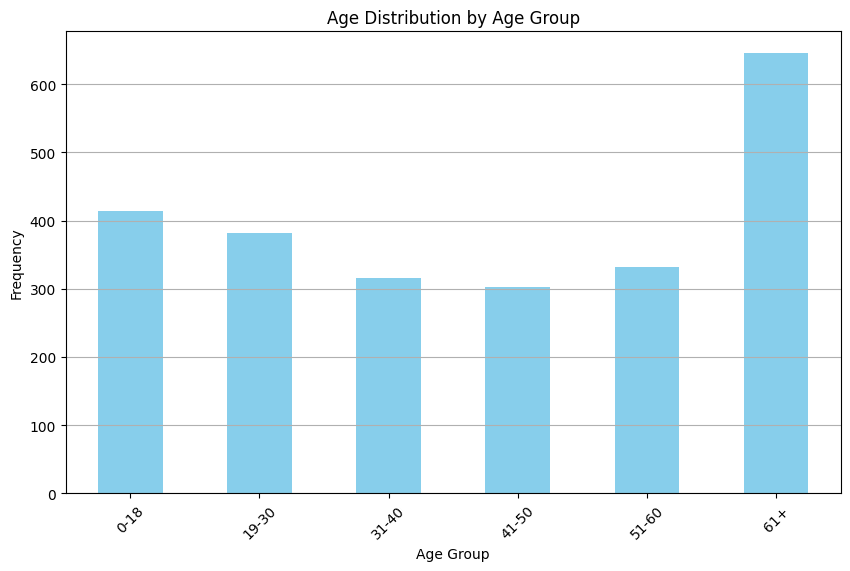

In [6]:
# Define age bins and labels
bins = [0, 18, 30, 40, 50, 60, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61+']

# Create a new column for age groups
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Count occurrences of each age group
age_group_counts = df['age_group'].value_counts().sort_index()

# Plot with Matplotlib
plt.figure(figsize=(10, 6))
age_group_counts.plot(kind='bar', color='skyblue')
plt.title('Age Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [7]:
#get categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

#get numerical columns
num_cols = df.select_dtypes(include=['int','float']).columns.tolist()

In [8]:
cat_cols

['DoctorInCharge']

In [9]:
num_cols

['PatientID',
 'Age',
 'Gender',
 'Ethnicity',
 'EducationLevel',
 'BMI',
 'Smoking',
 'PhysicalActivity',
 'DietQuality',
 'SleepQuality',
 'PollutionExposure',
 'PollenExposure',
 'DustExposure',
 'PetAllergy',
 'FamilyHistoryAsthma',
 'HistoryOfAllergies',
 'Eczema',
 'HayFever',
 'GastroesophagealReflux',
 'LungFunctionFEV1',
 'LungFunctionFVC',
 'Wheezing',
 'ShortnessOfBreath',
 'ChestTightness',
 'Coughing',
 'NighttimeSymptoms',
 'ExerciseInduced',
 'Diagnosis']

In [23]:
df.drop(['PatientID','DoctorInCharge','age_group'],axis=1, inplace = True)

In [24]:
# Define features (X) by dropping the target column
X = df.drop('Diagnosis', axis=1)

# Define target (y) by selecting the target column
y = df["Diagnosis"]

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [27]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': uniform(0.001, 100),
            'solver': ['liblinear', 'saga']
        }
    },
    'RidgeClassifier': {
        'model': RidgeClassifier(random_state=42),
        'params': {
            'alpha': uniform(0.01, 100),
            'solver': ['auto', 'sparse_cg', 'lsqr']
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 3, 5, 7, 10],
            'min_samples_split': randint(2, 11),
            'min_samples_leaf': randint(1, 5),
            'criterion': ['gini', 'entropy']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': randint(50, 201),
            'max_depth': [None, 3, 5, 7, 10],
            'min_samples_split': randint(2, 11),
            'min_samples_leaf': randint(1, 5),
            'criterion': ['gini', 'entropy']
        }
    },
    'AdaBoostClassifier': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': randint(50, 201),
            'learning_rate': uniform(0.01, 1.0)
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': randint(50, 201),
            'learning_rate': uniform(0.01, 0.2),
            'max_depth': randint(3, 8),
            'subsample': uniform(0.5, 0.5)
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': randint(3, 10),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False),
        'params': {
            'n_estimators': randint(50, 201),
            'learning_rate': uniform(0.01, 0.3),
            'max_depth': randint(3, 11),
            'subsample': uniform(0.5, 0.5),
            'colsample_bytree': uniform(0.5, 0.5),
            'gamma': uniform(0, 1)
        }
    }
}

In [28]:
# Function to evaluate a classification model
def evaluate_model(model, params, X_train, y_train, X_test, y_test):
    # Perform randomized search
    grid_search = RandomizedSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    grid_search.fit(X_train, y_train)

    # Get the best model and predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Model: {best_model}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy Score: {accuracy}")
    print("Classification Report:")
    print(report)
    print("=======================================")

    return best_model, accuracy




In [29]:
adjusted_accuracies = {}
all_models = {}

for model_name, model_info in models.items():
    print(f"Evaluating and Training {model_name}...")
    best_model, accuracy = evaluate_model(model_info['model'], model_info['params'], X_train, y_train, X_test, y_test)
    adjusted_accuracies[model_name] = accuracy
    all_models[model_name] = best_model

    # Save the model
    with open(f"{model_name}.pkl", 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Model {model_name} saved to {model_name}.pkl")

Evaluating and Training LogisticRegression...
Model: LogisticRegression(C=37.455011884736244, max_iter=1000, random_state=42,
                   solver='liblinear')
Best parameters: {'C': 37.455011884736244, 'solver': 'liblinear'}
Accuracy Score: 0.9519832985386222
Classification Report:
{'0': {'precision': 0.9519832985386222, 'recall': 1.0, 'f1-score': 0.9754010695187166, 'support': 456}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23}, 'accuracy': 0.9519832985386222, 'macro avg': {'precision': 0.4759916492693111, 'recall': 0.5, 'f1-score': 0.4877005347593583, 'support': 479}, 'weighted avg': {'precision': 0.9062722006964753, 'recall': 0.9519832985386222, 'f1-score': 0.9285655275585277, 'support': 479}}
Model LogisticRegression saved to LogisticRegression.pkl
Evaluating and Training RidgeClassifier...
Model: RidgeClassifier(alpha=37.464011884736244, random_state=42)
Best parameters: {'alpha': 37.464011884736244, 'solver': 'auto'}
Accuracy Score: 0.95198329853862

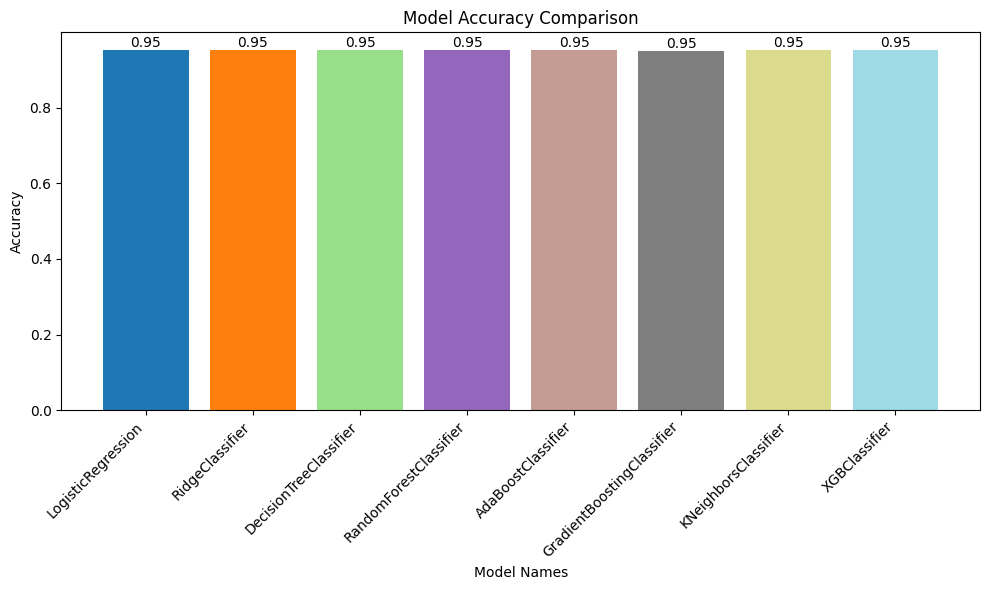

In [30]:
import matplotlib.pyplot as plt

# Sample data: Replace with actual data from adjusted_accuracies
model_names = list(adjusted_accuracies.keys())
accuracies = list(adjusted_accuracies.values())

# Generate a list of colors for each bar
colors = plt.cm.get_cmap('tab20', len(model_names))

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=[colors(i) for i in range(len(model_names))])

# Add labels and title
plt.xlabel('Model Names')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45, ha='right')

# Show accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Display the chart
plt.tight_layout()
plt.savefig('model_accuracy_comparison.png')
plt.show()
